# Baseline Logistic Regression Model

In [1]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
from scipy.stats import stats
from scipy.stats import norm
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import proportions_ztest
import math

## Dropping Features with High Collinearity

In [2]:
#load data frame with expanding  avgs since 2009 season
infile = open('../PickledFiles/gamlogsS09', 'rb')
gamelogsS09 = pickle.load(infile)
infile.close

<function BufferedReader.close>

In [3]:
#extracting relevant data
cols_to_keep = [col for col in gamelogsS09.columns if col.startswith(('Avg', 'pct'))]
cols_to_keep = ['Date'] + cols_to_keep + ['HomeWin']

In [4]:
rel_stats = gamelogsS09[cols_to_keep]


In [5]:
rel_stats.replace(np.inf,np.nan, inplace=True)

/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [6]:
rel_stats.iloc[:,1:50].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24298 entries, 0 to 24297
Data columns (total 49 columns):
pctW_HSP             24224 non-null float64
pctL_HSP             24224 non-null float64
pctSho_HSP           24224 non-null float64
AvgIP_HSP            24224 non-null float64
AvgH_HSP             24224 non-null float64
AvgR_HSP             24224 non-null float64
AvgER_HSP            24224 non-null float64
AvgHR_HSP            24224 non-null float64
AvgBB_HSP            24224 non-null float64
AvgK_HSP             24224 non-null float64
AvgHBP_HSP           24224 non-null float64
AvgBK_HSP            24224 non-null float64
AvgWP_HSP            24224 non-null float64
AvgERA_HSP           24224 non-null float64
AvgFIPnoConst_HSP    24224 non-null float64
pctW_VSP             24222 non-null float64
pctL_VSP             24222 non-null float64
pctSho_VSP           24222 non-null float64
AvgIP_VSP            24222 non-null float64
AvgH_VSP             24222 non-null float64
AvgR_VSP   

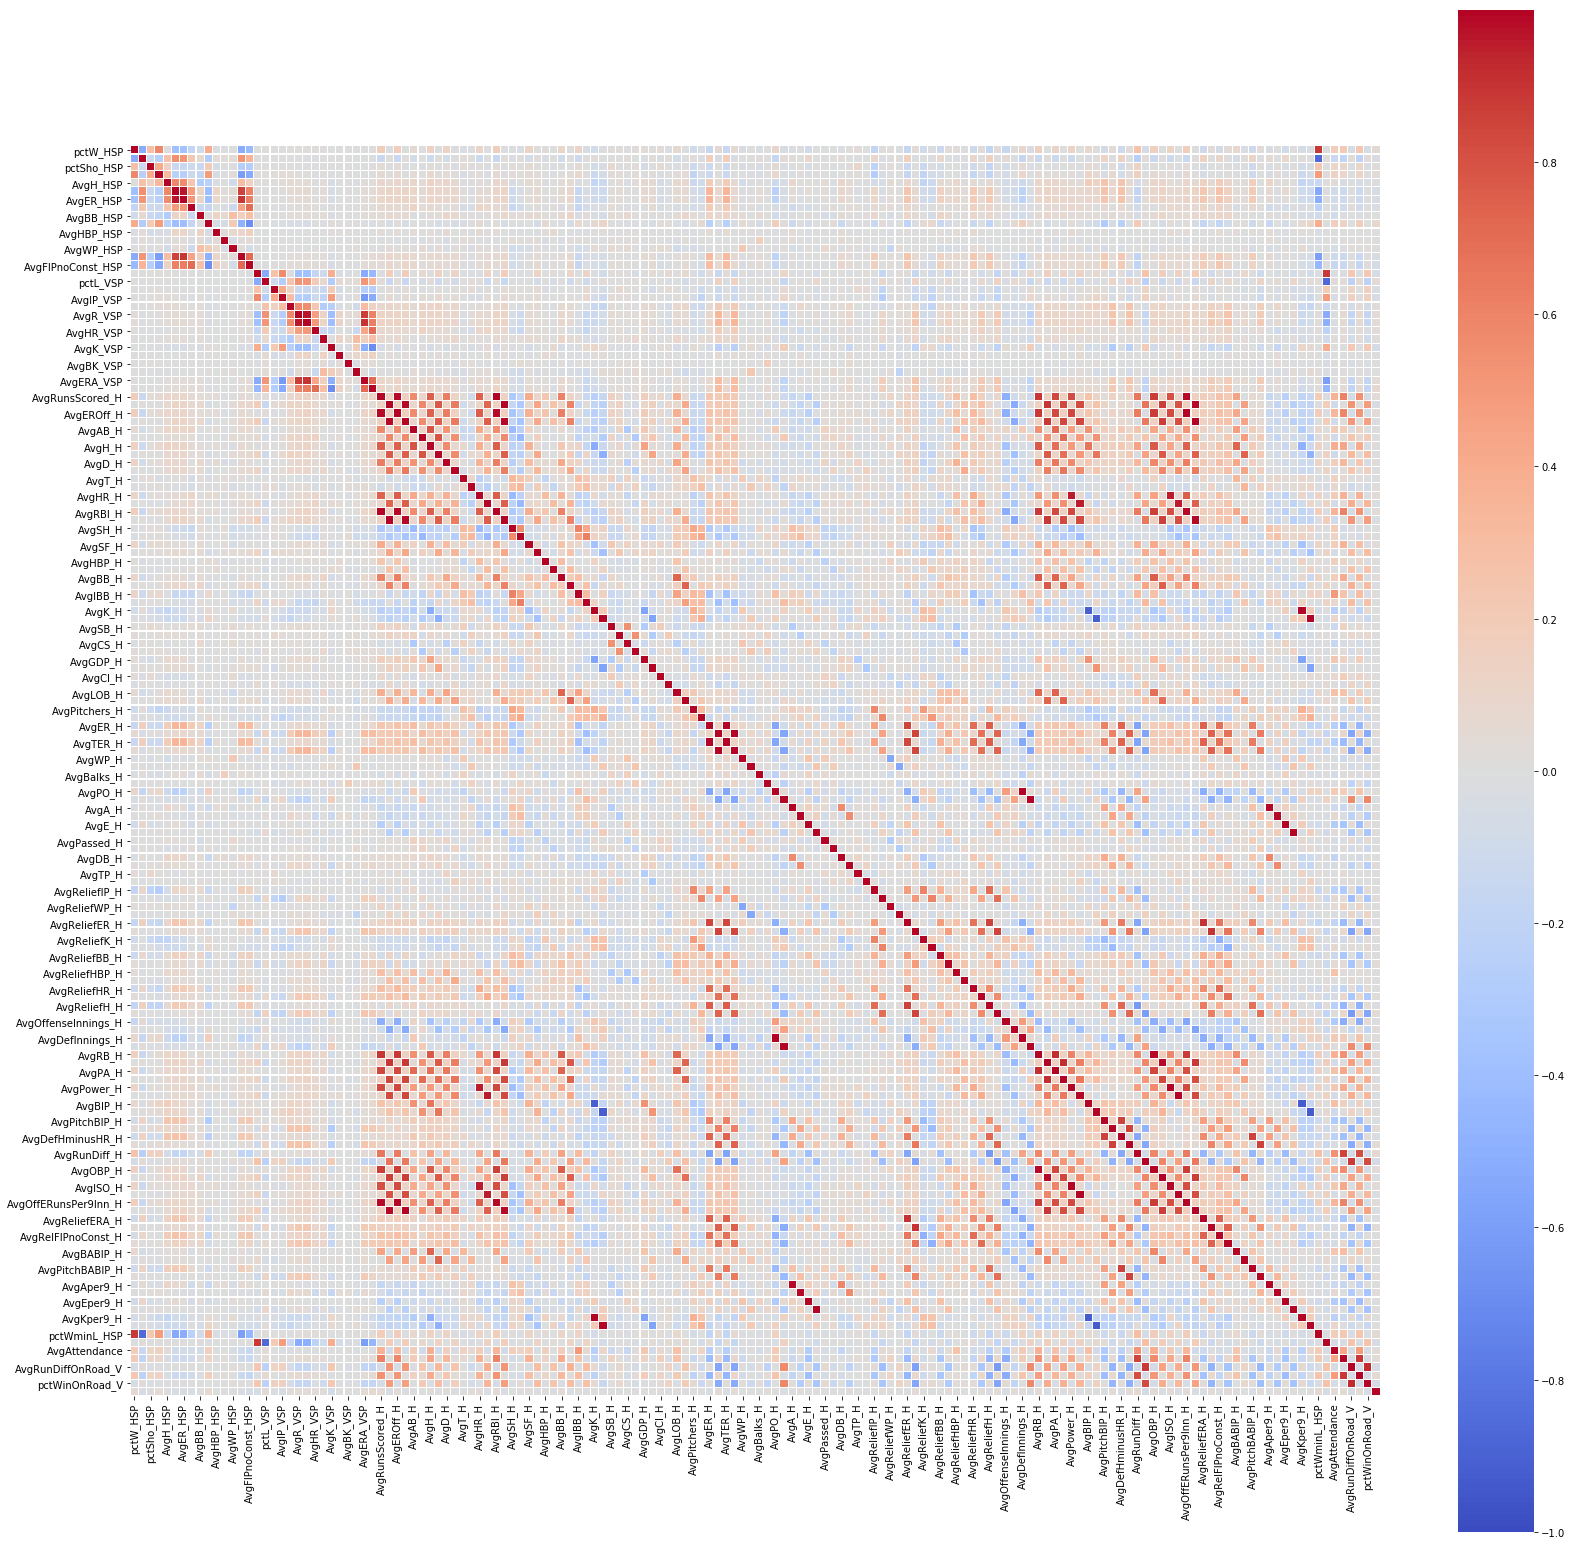

In [7]:
#correlation matrix revisited
corr_mat = rel_stats.corr()
plt.figure(figsize=(28,28))
cbar_kws = { 'ticks' : list(np.arange(-1,1,0.2)) }

sns.heatmap(corr_mat, cmap='coolwarm', vmin=-1, cbar_kws=cbar_kws, linewidth=.1, square=True)
plt.savefig('correlation_heatmap.png', dpi=300)

In [8]:
sorted_corrs = corr_mat.unstack().sort_values(ascending=False)
sorted_corrs[sorted_corrs==1].shape

(152,)

In [9]:
high_corrs = sorted_corrs[(abs(sorted_corrs) > 0.7) & (abs(sorted_corrs) !=1)]
print(high_corrs.shape[0])

330


In [10]:
high_corrs = high_corrs.drop_duplicates(keep = 'first')
high_corrs.shape[0]

165

In [11]:
high_corrs

AvgDefInnings_H       AvgPO_H                 0.999903
AvgDefInnings_V       AvgPO_V                 0.999899
AvgTER_V              AvgER_V                 0.999476
AvgER_H               AvgTER_H                0.999433
AvgEper9_V            AvgE_V                  0.998629
AvgEper9_H            AvgE_H                  0.998546
AvgOffERunsPer9Inn_H  AvgEROff_H              0.998150
AvgOffERunsPer9Inn_V  AvgEROff_V              0.998148
AvgKper9_H            AvgK_H                  0.997201
AvgKper9_V            AvgK_V                  0.997105
AvgRBI_H              AvgRunsScored_H         0.996486
AvgRBI_V              AvgRunsScored_V         0.996365
AvgISO_H              AvgPower_H              0.995959
AvgPower_V            AvgISO_V                0.995855
AvgRBI_H              AvgEROff_H              0.991912
AvgRBI_V              AvgEROff_V              0.991867
AvgRBI_H              AvgOffERunsPer9Inn_H    0.991193
AvgEROff_V            AvgRunsScored_V         0.990947
AvgA_V    

In [12]:
#drop highly correlated features
to_drop_home = ['AvgPO_H', 'AvgER_H','AvgTER_H','AvgE_H', 'AvgK_H','AvgRunsScored_H','AvgPower_H','AvgEROff_H',
                'AvgA_H','pctW_HSP','pctL_HSP','AvgRBI_H','AvgRB_H','AvgHR_H', 'AvgBIP_H', 'AvgDefHminusHR_H', 
                'AvgReliefK_H','AvgReliefER_H', 'AvgR_HSP', 'AvgER_HSP','AvgPA_H', 'AvgAB_H', 'AvgRunDiff_H',
                'AvgH_H', 'AvgBB_H','AvgOffERunsPer9Inn_H','AvgBK_HSP', 'AvgReliefERA_H', 'AvgERA_HSP','AvgReliefHR_H', 
                'AvgPitchBIP_H', 'AvgHR_HSP', 'AvgBB_HSP', 'AvgHBP_HSP', 'AvgReliefBB_H','AvgReliefHBP_H', 'AvgWP_H', 
                'AvgD_H', 'AvgT_H', 'AvgK_HSP', 'AvgOffenseInnings_H', 'AvgDefInnings_H','AvgReliefH_H', 'AvgH_HSP',
                'AvgHBP_H','AvgBalks_H','AvgKper9_H', 'AvgBABIP_H', 'AvgLOB_H', 'AvgPitchers_H']

to_drop = to_drop_home.copy()
for home_feat in to_drop_home:
    if home_feat.endswith('H'):
        visit_feat = home_feat[:-1] + 'V'
    else:
        visit_feat = home_feat[:-3] + 'VSP'
    to_drop.append(visit_feat)

In [13]:
#to_drop = to_drop + ['AvgRunDiffAtHome_H','AvgRunDiffOnRoad_V','pctWinAtHome_H','pctWinOnRoad_V']
to_drop = to_drop + ['pctWinAtHome_H','pctWinOnRoad_V']
len(to_drop)

102

In [14]:
cols_to_keep = rel_stats.drop(to_drop, axis=1)

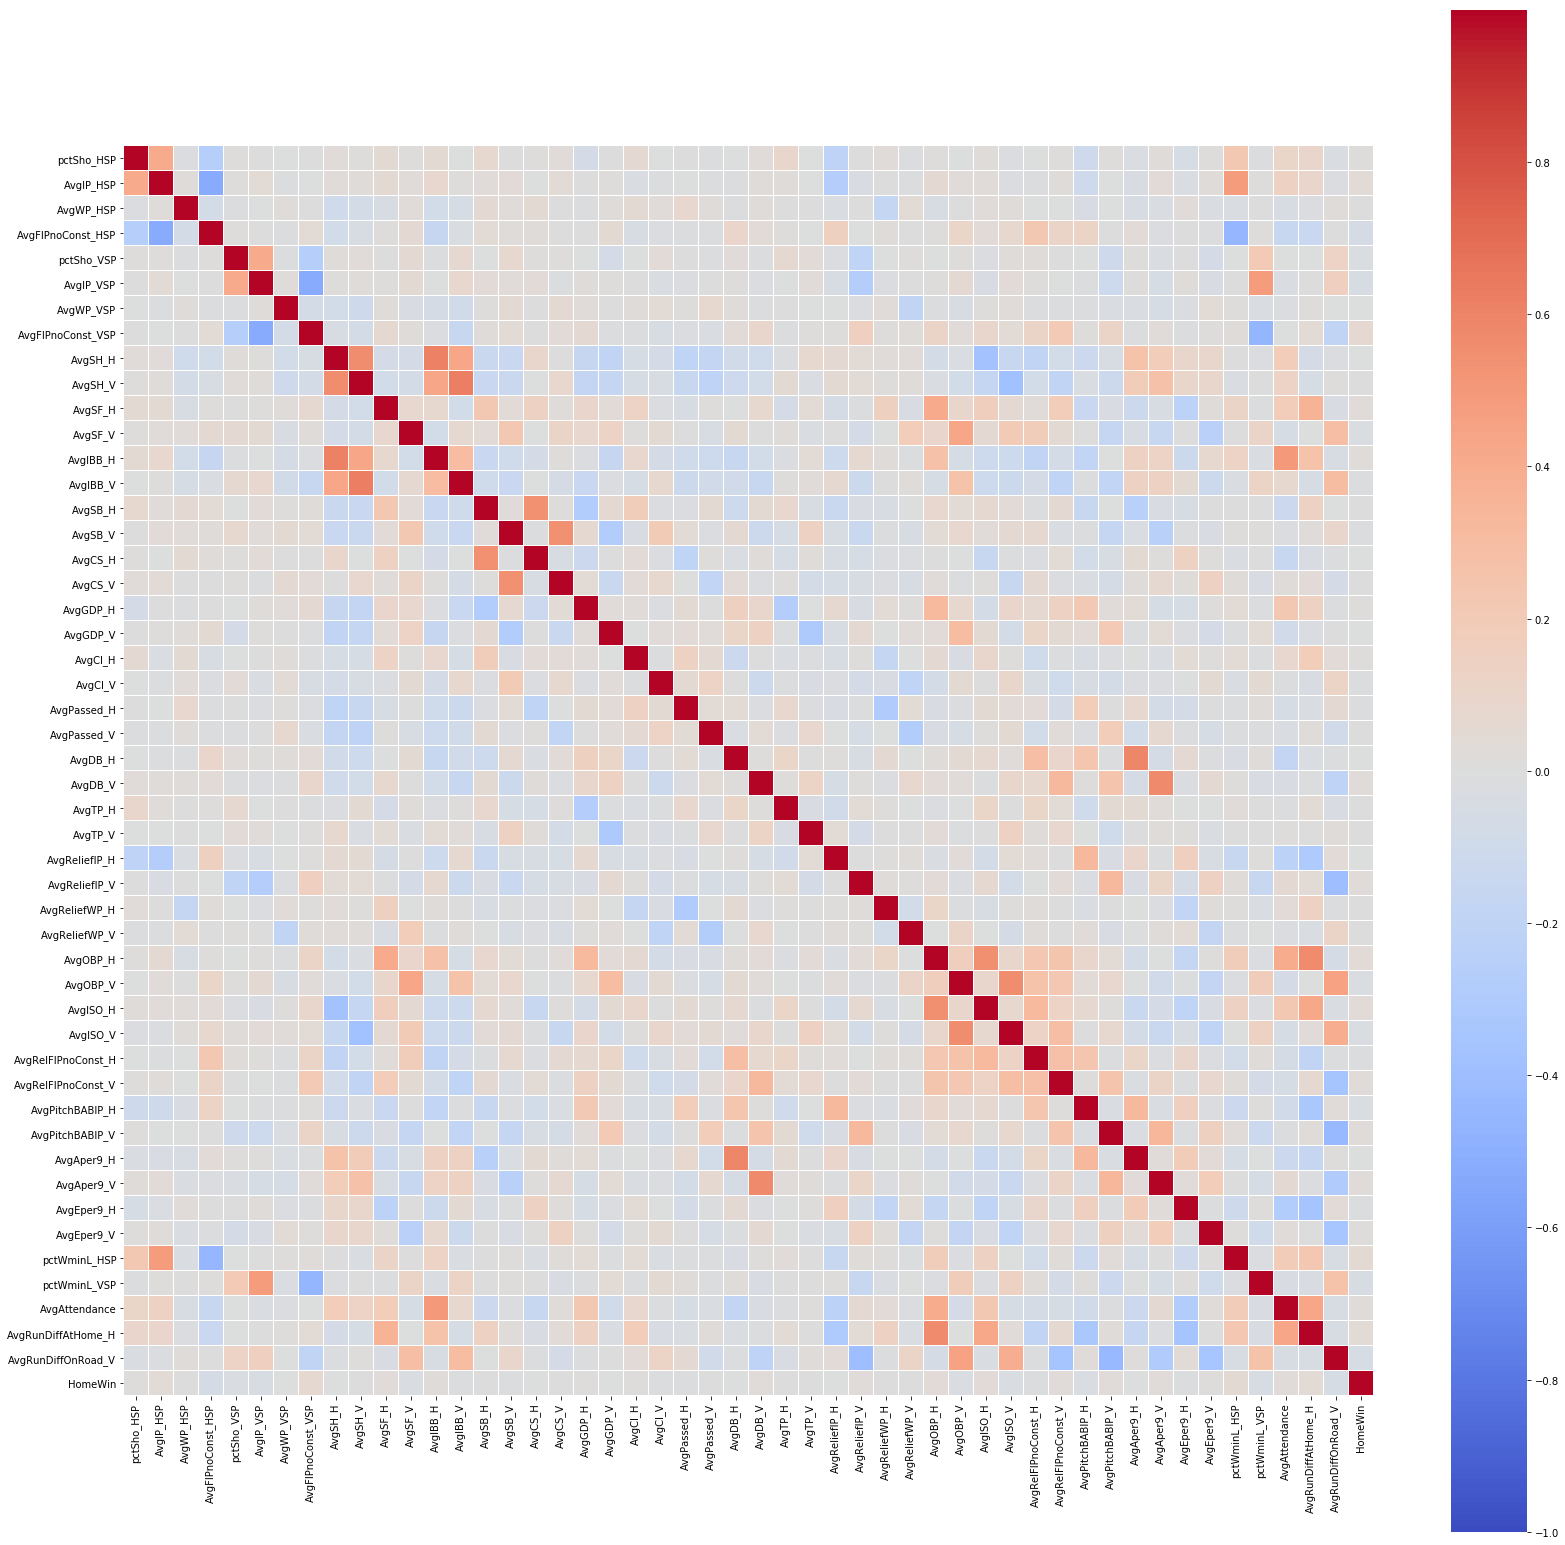

In [15]:
#correlation matrix revisited
corr_mat2 = cols_to_keep.corr()
plt.figure(figsize=(28,28))
cbar_kws = { 'ticks' : list(np.arange(-1,1,0.2)) }

sns.heatmap(corr_mat2, cmap='coolwarm', vmin=-1, cbar_kws=cbar_kws, linewidth=.1, square=True)
plt.savefig('correlation_heatmap_sub.png', dpi=300)

In [16]:
sorted_corrs2 = corr_mat2.unstack().sort_values(ascending=False)
sorted_corrs2[sorted_corrs2==1].shape

(50,)

In [17]:
high_corrs2 = sorted_corrs2[(abs(sorted_corrs2) > 0.7) & (abs(sorted_corrs2) !=1)]
high_corrs2 = high_corrs2.drop_duplicates(keep = 'first')
print(high_corrs2.shape[0])
high_corrs2

0


Series([], dtype: float64)

In [18]:
cols_to_keep.shape

(24298, 51)

In [19]:
#split into train and test sets

through2017 = cols_to_keep[cols_to_keep.Date.dt.year < 2018]

#remove April 2009 data because there are a lot of nulls
through2017 = through2017[through2017.Date > '2009-04-30']

season2018 = cols_to_keep[cols_to_keep.Date.dt.year == 2018]
Xtrain = through2017.iloc[:,1:-1]
#use 2018 season as test data
Xtest = season2018.iloc[:,1:-1]
ytrain = through2017.iloc[:,-1]
ytest = season2018.iloc[:,-1]

In [20]:
Xtrain.iloc[:,125:].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21544 entries, 323 to 21866
Empty DataFrame

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


scaler = StandardScaler()
Xtrain_scld = scaler.fit_transform(Xtrain)
Xtest_scld = scaler.transform(Xtest)


#Cross VALIDATION
param_grid = {'C': [0.001, 0.1, 1, 10, 100]}
logistic = LogisticRegression(solver = 'lbfgs')
logreg_cv = GridSearchCV(logistic, param_grid, cv = 5)
fitted = logreg_cv.fit(Xtrain_scld, ytrain)
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))



Tuned Logistic Regression Parameters: {'C': 0.001}
Best score is 0.5492944671370219


In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

ypred = fitted.predict(Xtest_scld)



print("[Training Classification Report:]")
print(classification_report(ytrain, fitted.predict(Xtrain_scld)))
print('Training Accuracy: ',accuracy_score(fitted.predict(Xtrain_scld), ytrain))
print('')
print("[Test Classification Report:]")
print(classification_report(ytest, ypred))
print('Test Accuracy: ', accuracy_score(ypred, ytest))

[Training Classification Report:]
              precision    recall  f1-score   support

           0       0.55      0.27      0.36      9948
           1       0.56      0.81      0.66     11596

   micro avg       0.56      0.56      0.56     21544
   macro avg       0.55      0.54      0.51     21544
weighted avg       0.55      0.56      0.52     21544

Training Accuracy:  0.5585313776457482

[Test Classification Report:]
              precision    recall  f1-score   support

           0       0.55      0.24      0.34      1148
           1       0.55      0.82      0.66      1283

   micro avg       0.55      0.55      0.55      2431
   macro avg       0.55      0.53      0.50      2431
weighted avg       0.55      0.55      0.51      2431

Test Accuracy:  0.5475113122171946


In [23]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

yprobs = fitted.predict_proba(Xtest_scld)[:,1]
fpr, tpr, threshold = roc_curve(ytest,  yprobs)
roc_auc = auc(fpr, tpr)
print('AUC: ', roc_auc)

AUC:  0.560206370630681


In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest, ypred)

array([[ 279,  869],
       [ 231, 1052]])

In [25]:
len(Xtrain_scld[1])

49

In [26]:
yprobs = fitted.predict_proba(Xtest)


In [27]:
rel_cols = list(cols_to_keep.columns)
rel_cols

['Date',
 'pctSho_HSP',
 'AvgIP_HSP',
 'AvgWP_HSP',
 'AvgFIPnoConst_HSP',
 'pctSho_VSP',
 'AvgIP_VSP',
 'AvgWP_VSP',
 'AvgFIPnoConst_VSP',
 'AvgSH_H',
 'AvgSH_V',
 'AvgSF_H',
 'AvgSF_V',
 'AvgIBB_H',
 'AvgIBB_V',
 'AvgSB_H',
 'AvgSB_V',
 'AvgCS_H',
 'AvgCS_V',
 'AvgGDP_H',
 'AvgGDP_V',
 'AvgCI_H',
 'AvgCI_V',
 'AvgPassed_H',
 'AvgPassed_V',
 'AvgDB_H',
 'AvgDB_V',
 'AvgTP_H',
 'AvgTP_V',
 'AvgReliefIP_H',
 'AvgReliefIP_V',
 'AvgReliefWP_H',
 'AvgReliefWP_V',
 'AvgOBP_H',
 'AvgOBP_V',
 'AvgISO_H',
 'AvgISO_V',
 'AvgRelFIPnoConst_H',
 'AvgRelFIPnoConst_V',
 'AvgPitchBABIP_H',
 'AvgPitchBABIP_V',
 'AvgAper9_H',
 'AvgAper9_V',
 'AvgEper9_H',
 'AvgEper9_V',
 'pctWminL_HSP',
 'pctWminL_VSP',
 'AvgAttendance',
 'AvgRunDiffAtHome_H',
 'AvgRunDiffOnRoad_V',
 'HomeWin']

In [28]:
outfile = open('../PickledFiles/rel_cols', 'wb')
pickle.dump(rel_cols, outfile)
outfile.close()

# Conclusions